# Data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


pd.set_option('display.max_rows', 500)

In [2]:
# !pip install coub-api

In [3]:
import os
from coub_api import CoubApi
from coub_api.schemas.constants import Period
from coub_api.schemas.constants import Category


api = CoubApi()


In [4]:

def get_category_data(current_page=1, max_page=0, category=Category.ANIMALS):
    """
    Parses the category timeline data from the Coub website via API app and stores them into a dataframe.
    Arguments:
        :current_page - starting/current page. Default - 1;
        :max_page - maximum page to load set by user. Default - 0 - loads all pages in the category;
        :category - view category. Read coub documentation for details.
    Returns:
        :data - resulting dataframe with coub metadata of interest
    """
    
    if max_page <= 0:
        max_page = api.timeline.community(category=category, per_page=25).total_pages
    
    data = []
    
    while current_page <= max_page:
        try:
            response = api.timeline.community(category=category, page=current_page, per_page=25)
            if current_page % 50 == 0:
                print(f"processing page {current_page} of {max_page}")
            for coub in response.coubs:
                data.append([
                            coub.channel.id,
                            coub.channel.title,
                            coub.channel.followers_count,
                            coub.channel.following_count,
                            coub.id,
                            coub.title,
                            coub.external_download.service_name if coub.external_download else 'local',
                            coub.created_at, 
                            coub.duration,
                            coub.views_count,
                            coub.recoubs_count,
                            coub.likes_count,
                            coub.dislikes_count,
                            coub.age_restricted,
                            coub.banned,
                            [i.title for i in coub.tags],
                            [i.title for i in coub.categories][0],
                            ''.join([i for i in coub.file_versions.html5.video.high.url]),
                            ]
                           )
            current_page += 1
            
        except:
            print(f'page:{current_page} - error making a request...')
            current_page += 1
            pass
    
    columns = ['channel_id', 'channel_title', 'channel_followers_count', 'channel_following_count',
               'id', 'title',
               'external_download', 
               'created_at', 'duration', 'views_count', 
               'recoubs_count','likes_count','dislikes_count', 'age_restricted', 
               'banned', 'tags', 
               'category_title','url_big']
    data = pd.DataFrame(data).apply(pd.Series)
    data.columns = columns
    return data
   
    
    
def _like_type(coub_id, data):
    current_like_page=1
    max_like_page = api.coub_metadata.likes_list(coub_id).total_pages

    while current_like_page <= max_like_page:
        try:
            response = api.coub_metadata.likes_list(coub_id,page=current_like_page)

            for user in response.channels:
                data.append([
                            coub_id,
                            user.id,
                            user.title,
                            user.followers_count,
                            user.following_count,
                            'like'
                            ]
                           )
            current_like_page += 1

        except:
            print(f'like page:{current_like_page} - error making a request...')
            current_like_page += 1
            pass



def _repost_type(coub_id, data):
    current_repost_page=1
    max_repost_page = api.coub_metadata.recoubs_list(coub_id).total_pages
    while current_repost_page <= max_repost_page:
        try:
            response = api.coub_metadata.recoubs_list(coub_id, page=current_repost_page)
            for user in response.channels:
                data.append([
                            coub_id,
                            user.id,
                            user.title,
                            user.followers_count,
                            user.following_count,
                            'repost'
                            ]
                           )
            current_repost_page += 1

        except:
            print(f'repost page:{current_repost_page} - error making a request...')
            current_repost_page += 1
            pass


def _compose_data(coub_id, data, reaction_type='all'):
    
    data = []
    if reaction_type == 'like':
        _like_type(coub_id, data)
    elif reaction_type == 'repost':
        _repost_type(coub_id, data)
    elif reaction_type == 'all':
        _like_type(coub_id, data)
        _repost_type(coub_id, data)
    
    columns = ['coub_id','user_id', 'user_name', 'user_followers_count', 'user_following_count','reaction_type']
    data = pd.DataFrame(data).apply(pd.Series)
    data.columns = columns
    
    return data


def get_coub_reaction_list(coub_ids, reaction_type='all'):
    """
    Parses the coub like_list and repost_list metadata from the Coub website via API app and stores them into a dataframe.
    Arguments:
        :coub_ids - list of coub IDs;
        :reaction_type - type of reactions to parse: ['like','repost','all']
    Returns:
        :data - resulting dataframe with coub reaction list metadata
    """
    
    assert reaction_type in ['like','repost','all'], "Wrong reaction_type!"
    
    reaction_list_composed = pd.DataFrame()
    
    for coub_id in coub_ids:
        data = []
        data_df = _compose_data(coub_id, data, reaction_type=reaction_type)
        reaction_list_composed = pd.concat([reaction_list_composed, data_df])
    
    return reaction_list_composed





In [5]:
# !pip install demoji
import demoji
demoji.download_codes() 

... OK (Got response in 0.33 seconds)
Writing emoji data to /Users/apall/.demoji/codes.json ...
... OK


## Load items data

In [6]:
import pickle
import os
def load_data(func, path='input_data',file_name='category_data.pkl', overwrite=False, 
              mp_func=None, file_list=None):
    """
    Checks if data is on disk; if not - requests data and stores into a specified location.
    Arguments:
        :path - (str) - save directory path;
        :file_name - (str) - file name of the pickle dataframe;
        :overwrite - (bool) - whether to overwrite existing data on disk. Default is False.
    Returns:
        :data - resulting dataframe.
    """
    file_path = os.path.join(path,file_name)
    if not os.path.exists(file_path) or overwrite == True:
        if not os.path.exists(path):
            os.makedirs(path)
        print('no data, sending requests ...')
        
        if mp_func:
            assert file_list is not None, "Provide file_list!"
            data = func(mp_func, file_list)
        else:
            data = func()
        
        data.to_pickle(file_path)
    else:
        print('data loaded from disk.')
        data = pd.read_pickle(file_path)
    
    return data


category_data = load_data(get_category_data, 
                          path='input_data',
                          file_name='category_data.pkl', 
                          overwrite=False)

data loaded from disk.


In [7]:
category_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3354 entries, 0 to 3353
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   channel_id               3354 non-null   int64              
 1   channel_title            3354 non-null   object             
 2   channel_followers_count  3354 non-null   int64              
 3   channel_following_count  3354 non-null   int64              
 4   id                       3354 non-null   int64              
 5   title                    3354 non-null   object             
 6   external_download        3354 non-null   object             
 7   created_at               3354 non-null   datetime64[ns, UTC]
 8   duration                 3354 non-null   float64            
 9   views_count              3354 non-null   int64              
 10  recoubs_count            3354 non-null   int64              
 11  likes_count              3354 

In [8]:
category_data.head(5).url_big.values

array(['https://coubsecure-s.akamaihd.net/get/b186/p/coub/simple/cw_file/1bb62fc447f/acdc6fe0b002ac4064342/muted_mp4_big_size_1603552051_muted_big.mp4',
       'https://coubsecure-s.akamaihd.net/get/b28/p/coub/simple/cw_file/51ac6cfdfbc/5e06dab1dca3f9a6de008/muted_mp4_big_size_1603659000_muted_big.mp4',
       'https://coubsecure-s.akamaihd.net/get/b155/p/coub/simple/cw_file/89ced6f6dd2/830327016ae1881077417/muted_mp4_big_size_1592858799_muted_big.mp4',
       'https://coubsecure-s.akamaihd.net/get/b56/p/coub/simple/cw_file/428dbf45f59/0875b7d6ce822fdb7d3b6/muted_mp4_big_size_1603582541_muted_big.mp4',
       'https://coubsecure-s.akamaihd.net/get/b85/p/coub/simple/cw_file/2de0d66002f/d12cbde28c3b0f4336645/muted_mp4_big_size_1603708344_muted_big.mp4'],
      dtype=object)

## Basic EDA & Preprocessing on items data

In [9]:
import unicodedata as ud
from nltk.corpus import stopwords
import re



def _is_latin(uchr):
    """
    Returns latin letters only;
    Arguments:
        :uchr - input letter string
    Returns:
        :latin_letters - string with latin letters only
        
    """
    latin_letters= {}
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

        
def _only_roman_chars(unistr):
    """
    Checks if all letters in a word are latin only. 
    """
    return all(_is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin


def _roman_tags(tags):
    """
    Fixes the tags list to contain the lower case latin words only.
    """
    if tags is not None and len(tags) > 0:
        res = [tag.lower() for tag in tags if _only_roman_chars(tag)]
        if len(res) > 0:
            return res
    
        
def _re_sub(s):
    pattern = r'\W+'
    return re.sub(pattern,' ',s).strip()
        
def _process_string(s):
    
    try:
        stop_words = stopwords.words("english")
        
        
        if type(s) == list:
            s = s[0]

        if len(demoji.findall(s)) > 0:
            words = list(set(_re_sub(s).split(' ') + ' '.join(list(demoji.findall(s).values())).split(' ') ))
        else:
            words = _re_sub(s).split(' ')

        res = []
        for word in words:
            if word not in stop_words:
                res.append(word.lower())
        return res
    except TypeError:
        return
    except IndexError:
        return


def fix_tags(df):
    title, tags = df
    tags = _roman_tags(tags)
    if tags is None or len(tags) == 0:
        if title:
            
            proc_string = _process_string(title)
            res = _roman_tags(proc_string)
                
            return res
    else:
        return tags
        

In [10]:
s = 'Little #kitty cat is so funny 😺😂😂'

_process_string(s)


['grinning', 'little', 'joy', 'cat', 'tears', 'face', 'funny', 'kitty']

**Comment** 

``Preprocess text columns & fill tags``.

1. extract emojis in text columns where present and convert them to text 
2. Remove non latin tags.
3. If tags are not present, look for latin coub title. If this is not present, look for external video latin title.  Make a flattened list out of string(s). Otherwise leave blank.
4. Keep only alphanumeric charachters in coub title


In [11]:
# since the comments may come in different languages, I am going to keep latin based comments only.

category_data['fixed_tags'] = category_data[['title','tags']].apply(fix_tags,axis=1)
category_data['title'] = category_data['title'].apply(lambda x: _re_sub(x).strip())
category_data.shape

(3354, 19)

In [12]:
category_data.id.unique().shape

(1334,)

Seems like we have multiple entries for the same video ID, let's see

In [13]:
category_data.sort_values(by='id').tail(5)

,channel_id,channel_title,channel_followers_count,channel_following_count,id,title,external_download,created_at,duration,views_count,recoubs_count,likes_count,dislikes_count,age_restricted,banned,tags,category_title,url_big,fixed_tags
2178,5127326,Ilya Galkov,18,11,156571636,КалейдосКот,Vk,2020-10-26 10:32:22+00:00,8.04,11269,39,206,0,False,False,"[кот, рыжий, cat, калейдоскоп]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b85/p/co...,[cat]
1538,5127326,Ilya Galkov,18,11,156571636,КалейдосКот,Vk,2020-10-26 10:32:22+00:00,8.04,11256,38,204,0,False,False,"[кот, рыжий, cat, калейдоскоп]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b85/p/co...,[cat]
3138,5127326,Ilya Galkov,18,11,156571636,КалейдосКот,Vk,2020-10-26 10:32:22+00:00,8.04,11286,39,207,0,False,False,"[кот, рыжий, cat, калейдоскоп]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b85/p/co...,[cat]
2158,5127326,Ilya Galkov,18,11,156571636,КалейдосКот,Vk,2020-10-26 10:32:22+00:00,8.04,11269,39,206,0,False,False,"[кот, рыжий, cat, калейдоскоп]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b85/p/co...,[cat]
1838,5127326,Ilya Galkov,18,11,156571636,КалейдосКот,Vk,2020-10-26 10:32:22+00:00,8.04,11262,39,206,0,False,False,"[кот, рыжий, cat, калейдоскоп]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b85/p/co...,[cat]


Okay, as seen, last sevral rows exactly illustrate the situation. There we have different **views_count** only, while other characteristics remain unchanged. I consider keeping only the rows with the most recent number of views. We also remove entries with NaNs.

In [14]:
category_data = category_data.groupby('id').max().reset_index().dropna()

In [15]:
category_data.shape

(1126, 19)

In [16]:
category_data[category_data.dislikes_count > 0]

,id,channel_id,channel_title,channel_followers_count,channel_following_count,title,external_download,created_at,duration,views_count,recoubs_count,likes_count,dislikes_count,age_restricted,banned,tags,category_title,url_big,fixed_tags
152,133069158,622710,thegolova,16,7,hello,YouTube,2019-12-29 15:40:30+00:00,8.28,32704,49,354,1,False,False,[],Animals & Pets,https://coubsecure-s.akamaihd.net/get/b123/p/c...,[hello]


In [17]:
category_data[category_data.age_restricted == True]

,id,channel_id,channel_title,channel_followers_count,channel_following_count,title,external_download,created_at,duration,views_count,recoubs_count,likes_count,dislikes_count,age_restricted,banned,tags,category_title,url_big,fixed_tags


In [18]:
category_data[category_data.banned == True]

,id,channel_id,channel_title,channel_followers_count,channel_following_count,title,external_download,created_at,duration,views_count,recoubs_count,likes_count,dislikes_count,age_restricted,banned,tags,category_title,url_big,fixed_tags


In [19]:
# since there's no restricted or banned videos, we drop these columns
category_data = category_data.drop(['age_restricted','banned'],axis=1)

In [20]:
# since we don't have sufficient dislikes data, we will randomly generate them, and the 
category_data.likes_count.describe()

count    1126.000000
mean      790.571048
std      1100.930918
min        33.000000
25%       274.250000
50%       428.500000
75%       708.500000
max      9947.000000
Name: likes_count, dtype: float64

In [21]:
category_data.dislikes_count = category_data.dislikes_count.apply(lambda x: np.random.randint(0,720) if x == 0 else x)


In [22]:
category_data.columns

Index(['id', 'channel_id', 'channel_title', 'channel_followers_count',
       'channel_following_count', 'title', 'external_download', 'created_at',
       'duration', 'views_count', 'recoubs_count', 'likes_count',
       'dislikes_count', 'tags', 'category_title', 'url_big', 'fixed_tags'],
      dtype='object')

In [23]:
category_data = category_data.reset_index(drop=True)

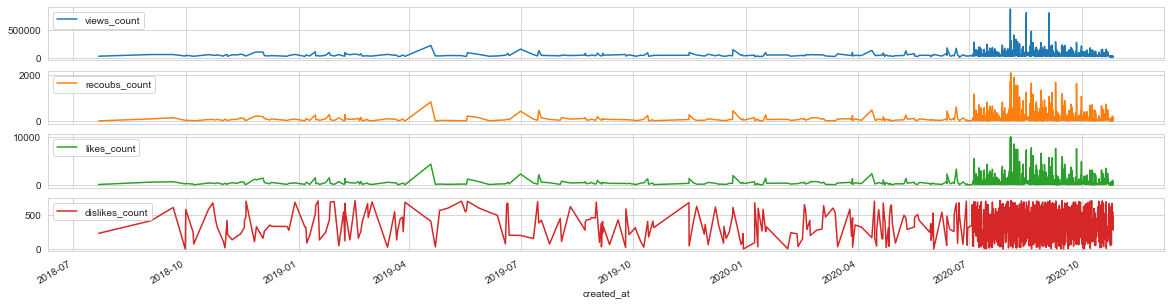

In [24]:
cols = ['views_count', 'recoubs_count', 'likes_count','dislikes_count']
axes = category_data.groupby(['created_at']).mean()[cols].plot(subplots=True, figsize=(20,5))
for ax in axes:
    ax.legend(loc=2);

It seems we have a peak of activity in our category **ANIMALS & PETS** starting in **July 2020**.

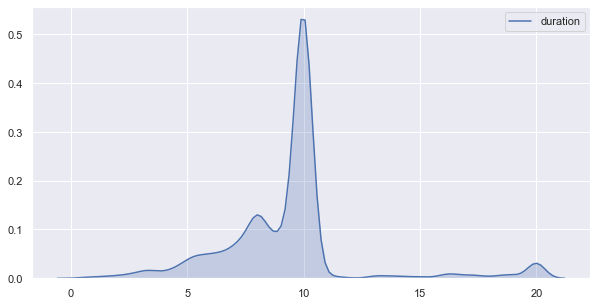

In [25]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.kdeplot(data=category_data['duration'], shade=True);

Seems like most of the videos are between 5 and 12 seconds long.

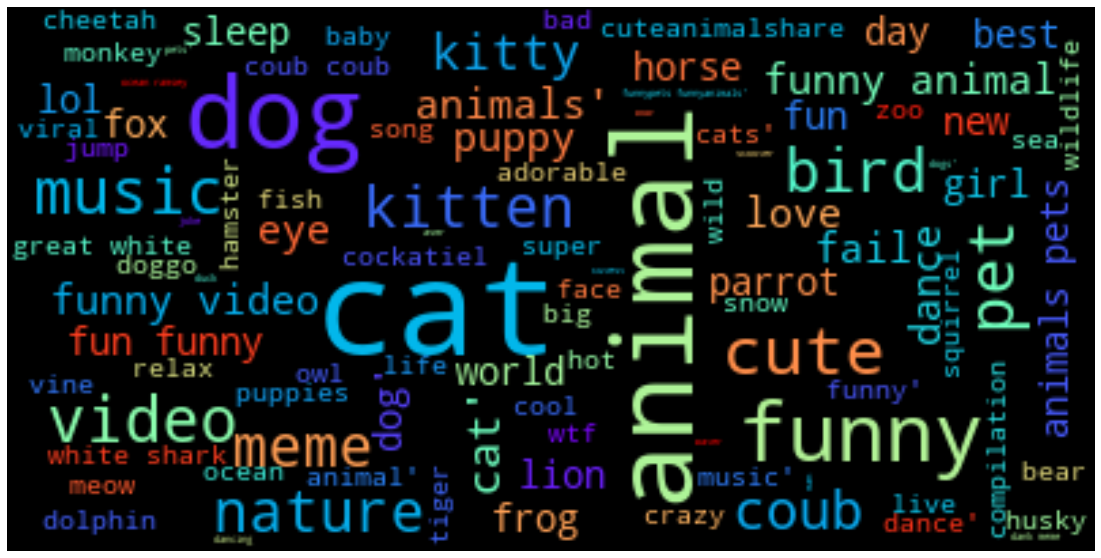

In [26]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = list(set(category_data['fixed_tags'].apply(lambda x: ', '.join(x)).values))
plt.rcParams['figure.figsize'] = (20, 10)
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="black", colormap='rainbow').generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

## Load user and likes data for selected videos

In [27]:
videos_list = category_data.id.values
videos_list[:5]

array([80296774, 84097236, 85799090, 86754880, 86806583])

In [28]:
len(videos_list)

1126

In [29]:
from multiprocessing import Pool, cpu_count
import tqdm
# from tqdm.notebook import tqdm


def multi_proc(func, file_list):
    """
    Multiprocessing computation.
    Arguments:
        :func - calculation function;
        :file_list - list of files to process;
    Returns:
        :merge_df - merged dataframe with func-results.
    """
    list_chunk = np.array_split(file_list, cpu_count())
    with Pool(cpu_count()) as p:
        merge_df = pd.concat(list(tqdm.tqdm(p.imap(func, list_chunk), total=len(file_list))))
    
    return merge_df


def multi_proc(func, file_list):
    """
    Multiprocessing computation.
    Arguments:
        :func - calculation function;
        :file_list - list of files to process;
    Returns:
        :merge_df - merged dataframe with func-results.
    """
    try:
        list_chunk = np.array_split(file_list, cpu_count())

        mp = Pool(cpu_count())
        merge_df = pd.concat(mp.map(func, list_chunk))
        mp.close()
        mp.join()

        return merge_df
    except:
        pass



In [30]:
coub_reaction_user_list_df_p1 = load_data(multi_proc,
                                       path='input_data',
                                       file_name='coub_reaction_user_list_df_p1.pkl', 
                                       overwrite=False, 
                                       mp_func=get_coub_reaction_list,
                                       file_list=videos_list[:300])

data loaded from disk.


In [31]:
coub_reaction_user_list_df_p1.coub_id.unique().shape

(300,)

In [32]:
coub_reaction_user_list_df_p2 = load_data(multi_proc,
                                       path='input_data',
                                       file_name='coub_reaction_user_list_df_p2.pkl', 
                                       overwrite=False, 
                                       mp_func=get_coub_reaction_list,
                                       file_list=videos_list[300:600])

data loaded from disk.


In [33]:
coub_reaction_user_list_df_p2.coub_id.unique().shape

(300,)

In [34]:
coub_reaction_user_list_df_p3 = load_data(multi_proc,
                                       path='input_data',
                                       file_name='coub_reaction_user_list_df_p3.pkl', 
                                       overwrite=False, 
                                       mp_func=get_coub_reaction_list,
                                       file_list=videos_list[600:])

coub_reaction_user_list_df_p3.coub_id.unique().shape

data loaded from disk.


(568,)

In [35]:
coub_reaction_user_list_df_all = pd.concat([coub_reaction_user_list_df_p1,coub_reaction_user_list_df_p2, coub_reaction_user_list_df_p3])


In [36]:
coub_reaction_user_list_df_all.coub_id.unique().shape

(1168,)

Now we have user-items data, i.e. the list of all videos from **Animals-Pets** category that each user liked or reposted.

In [37]:
coub_reaction_user_list_df_all.head()

,coub_id,user_id,user_name,user_followers_count,user_following_count,reaction_type
0,80296774,4798352,Tefomand76191,16,2679,like
1,80296774,4743899,Hygienis,47,4995,like
2,80296774,2994814,Pakyto,19,1755,like
3,80296774,4112500,Coes56603,7,12,like
4,80296774,682291,vova,25,3480,like


In [38]:
coub_reaction_user_list_df_all.shape, coub_reaction_user_list_df_all.user_id.unique().shape

((1111450, 6), (132466,))

In [39]:
# since users with non-latin names are more likely to like non-latin name videos, we remove them
coub_reaction_user_list_df_all['latin_name'] = coub_reaction_user_list_df_all.user_name.apply(_only_roman_chars)
coub_reaction_user_list_df_all = coub_reaction_user_list_df_all[coub_reaction_user_list_df_all['latin_name']==True]
coub_reaction_user_list_df_all = coub_reaction_user_list_df_all.drop('latin_name', axis=1)

In [40]:

coub_reaction_user_list_df_all.shape, coub_reaction_user_list_df_all.user_id.unique().shape

((838336, 6), (101043,))

In [41]:
coub_reaction_user_list_df_all[coub_reaction_user_list_df_all.reaction_type=='repost'].user_id.unique().shape

(23157,)

In [42]:
user_ids_all = coub_reaction_user_list_df_all.user_id.unique()
user_ids_repo = coub_reaction_user_list_df_all[coub_reaction_user_list_df_all.reaction_type=='repost'].user_id.unique()
user_ids_all.shape, user_ids_repo.shape


((101043,), (23157,))

## EDA on user-item data

In [43]:
coub_reaction_user_list_df_all.head()

,coub_id,user_id,user_name,user_followers_count,user_following_count,reaction_type
0,80296774,4798352,Tefomand76191,16,2679,like
1,80296774,4743899,Hygienis,47,4995,like
2,80296774,2994814,Pakyto,19,1755,like
3,80296774,4112500,Coes56603,7,12,like
4,80296774,682291,vova,25,3480,like


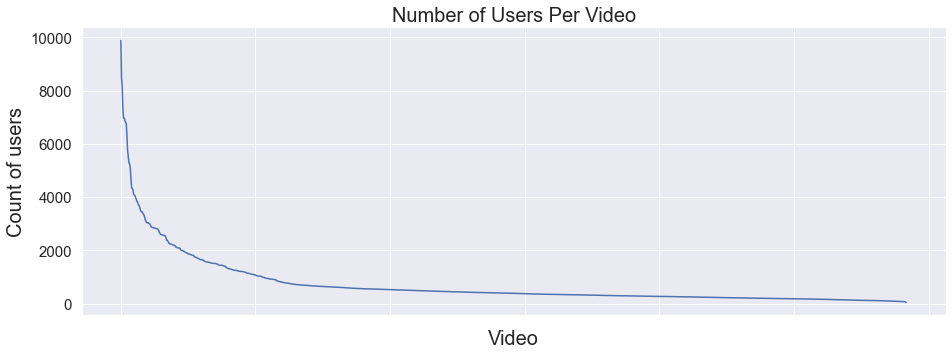

In [44]:

users_per_video = coub_reaction_user_list_df_all.groupby('coub_id').count()['user_id'].sort_values(ascending = False)


fig = plt.figure(figsize = (12, 4))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Users Per Video", fontsize = 20)
plt.xlabel("Video", fontsize = 20)
plt.ylabel("Count of users", fontsize = 20)
plt.plot(users_per_video.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

Makes sense, some videos are extremely popular while the mjority is on average.

In [45]:
followers_per_user = coub_reaction_user_list_df_all.groupby('user_id').mean()['user_followers_count'].sort_values(ascending = False).to_frame()

followers_per_user.head()

,user_followers_count
user_id,
1029078,9873944.0
411953,182009.0
411982,151888.0
548596,123762.0
411899,89137.0


Seems we have an extra popular user, for now will discard him to see how top 50 users perform.

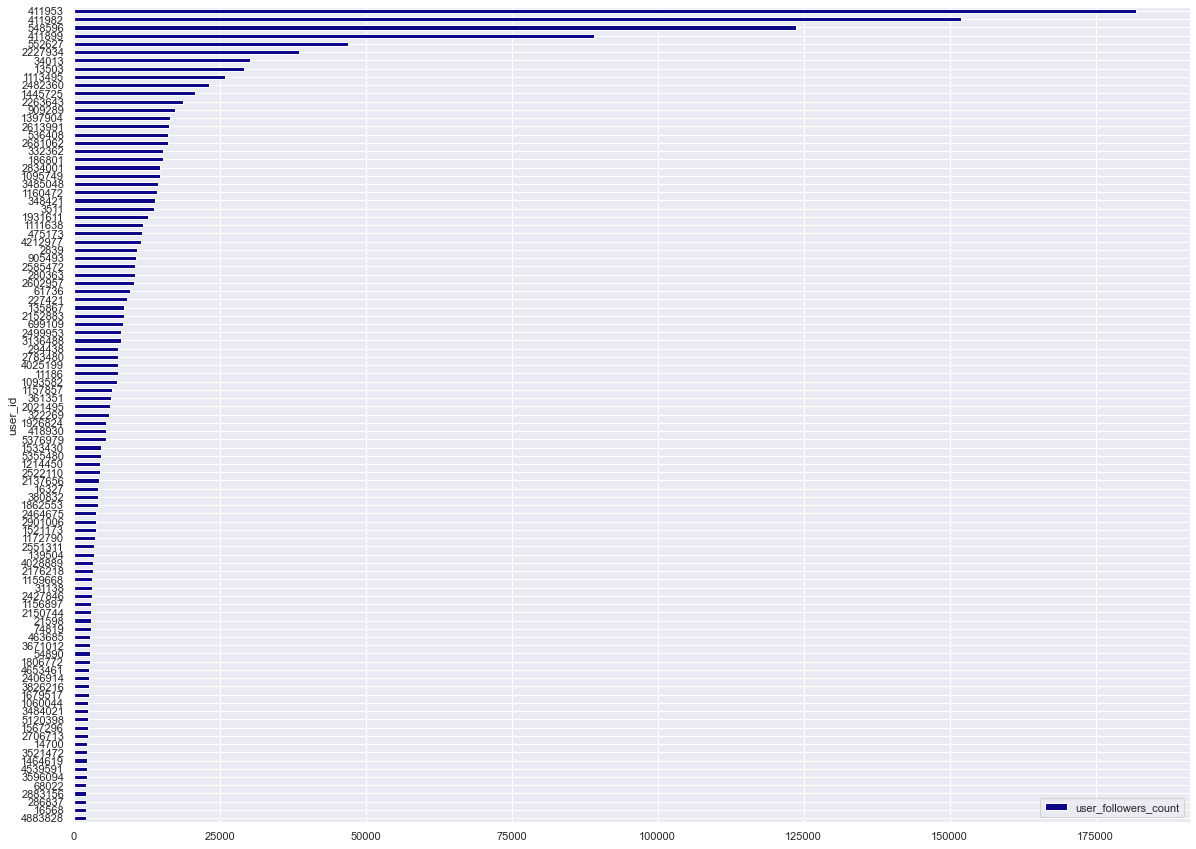

In [46]:
followers_per_user.iloc[1:100].sort_values(by='user_followers_count').plot.barh(colormap='plasma', figsize=(20,15));

In [47]:
followers_per_user.describe()

,user_followers_count
count,1.010430e+05
mean,1.353908e+02
std,3.107728e+04
min,0.000000e+00
25%,5.000000e+00
50%,1.500000e+01
75%,2.500000e+01
max,9.873944e+06


We have top 20 performers with extra high number of followers, another 20 over the midrange, while others are relatively inpopular, if I can say so. Yet the majority has not more than 25 followers.

In [48]:
following_per_user = coub_reaction_user_list_df_all.groupby('user_id').mean()['user_following_count'].sort_values(ascending = False).to_frame()

following_per_user.head()

,user_following_count
user_id,
418930,37864.0
68022,21487.0
77525,6566.0
1164186,5482.0
648389,5002.0


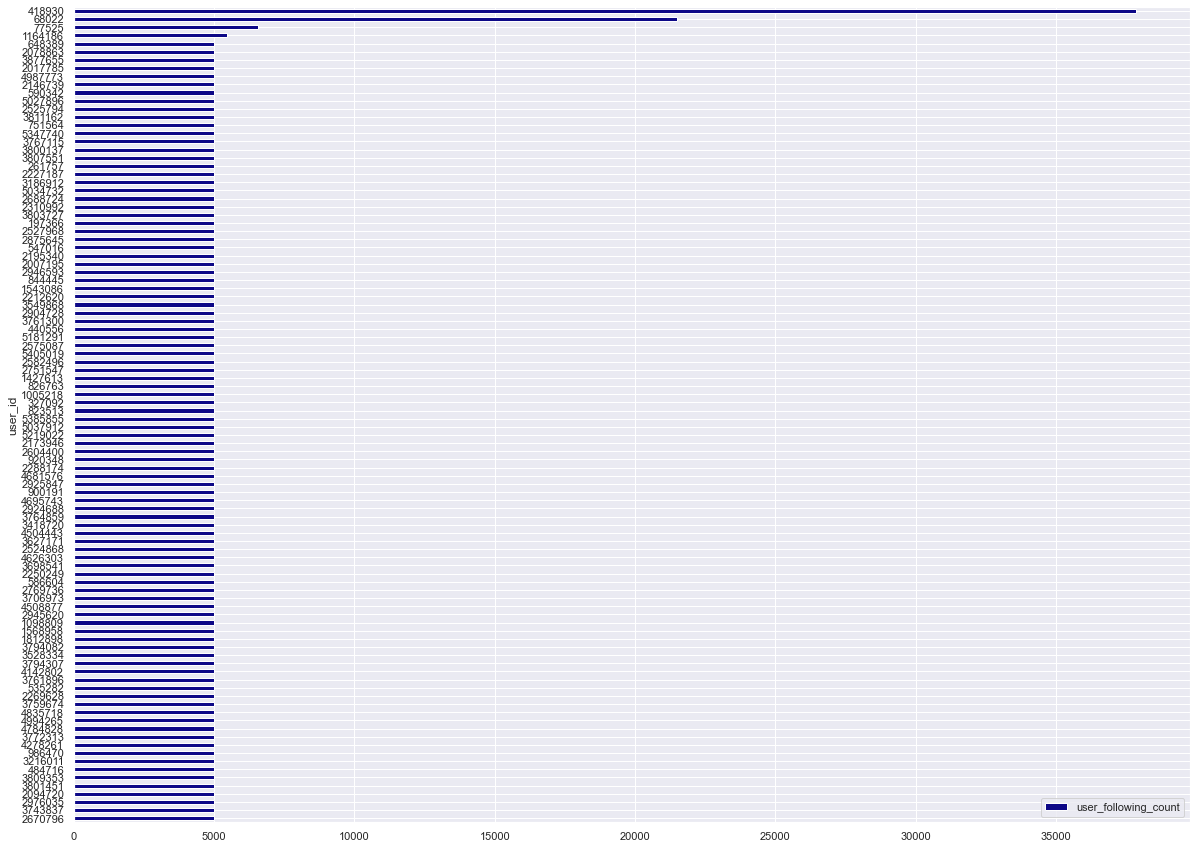

In [49]:
following_per_user.iloc[:100].sort_values(by='user_following_count').plot.barh(colormap='plasma', figsize=(20,15));

In [50]:
following_per_user.describe()

,user_following_count
count,101043.000000
mean,258.777488
std,1003.916249
min,0.000000
25%,11.000000
50%,12.000000
75%,19.000000
max,37864.000000


Here, the situation is different. We have only 3 top following users while the rest of top 100 users has roughly the same number of channels / other users they follow. More than 75% of them following up to 20 accounts only, which roughly corresponds to the followers trend. 

# Building the recommender

## Content based recommender w/o user rating

We'll create a simple recommender based on title, category and tags

### Item-Item recommendation

#### Creating a TF-IDF Vectorizer

The **TD-IDF** algorithm is used to weigh a keyword in any document and assign the importance to that keyword based on the number of times it appears in the document. Put simply, the higher the TF-IDF score (weight), the rarer and more important the term, and vice versa.

Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF-IDF weight of that term.

The **TF (term frequency)** of a word is the number of times it appears in a document. When you know it, you’re able to see if you’re using a term too often or too infrequently.

`TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).`

The **IDF (inverse document frequency)** of a word is the measure of how significant that term is in the whole corpus.

`IDF(t) = log_e(Total number of documents / Number of documents with term t in it).`

\begin{equation*}
w_{x,y} = tf_{x,y} * log \left( \frac{N}{df_x} \right),  
\end{equation*}

where:

- tf_{x,y} - frequency of *x* in *y*
- df_x - number of documents containing *x*
- N - total number of documents

In [51]:
category_data.head()

,id,channel_id,channel_title,channel_followers_count,channel_following_count,title,external_download,created_at,duration,views_count,recoubs_count,likes_count,dislikes_count,tags,category_title,url_big,fixed_tags
0,80296774,4631772,Akhmedzhanova Olesya,6,11,cat,local,2018-07-21 16:46:19+00:00,8.04,26221,19,175,233,[],Animals & Pets,https://coubsecure-s.akamaihd.net/get/b198/p/c...,[cat]
1,84097236,4150504,CoubPatrick,73,1,What does a fox say,YouTube,2018-09-02 07:53:33+00:00,9.44,55484,105,657,420,[],Animals & Pets,https://coubsecure-s.akamaihd.net/get/b110/p/c...,"[what, fox, say]"
2,85799090,438309,Zubor Zalán,211,98,Ride the worm,local,2018-09-20 11:53:08+00:00,10.00,55368,153,729,618,"[dune, worm, riding, soliders, worms, ferrari]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b87/p/co...,"[dune, worm, riding, soliders, worms, ferrari]"
3,86754880,4838580,ia,12,14,circles by sabaton,local,2018-09-30 08:05:16+00:00,1.80,28994,42,292,1,[],Animals & Pets,https://coubsecure-s.akamaihd.net/get/b6/p/cou...,"[circles, sabaton]"
4,86806583,124569,Anton Vanushin,223,9,moskoy cat in army now,UrlDownload,2018-09-30 18:31:19+00:00,9.88,41693,45,380,588,"[cat, army]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b7/p/cou...,"[cat, army]"


In [52]:
# to account for numeric statistics on reposts, likes and dislikes, we categorize them and will add to Tf-IDF vectorizer as columns

category_data['recoubs_count_cat'] = category_data['recoubs_count'].apply(lambda x: 'low' if x < category_data['recoubs_count'].quantile(0.5)
                                           else 'middle' if x >= category_data['recoubs_count'].quantile(0.5) and x < category_data['recoubs_count'].quantile(0.75)
                                           else 'high')

category_data['likes_count_cat'] = category_data['likes_count'].apply(lambda x: 'low' if x < category_data['likes_count'].quantile(0.5)
                                           else 'middle' if x >= category_data['likes_count'].quantile(0.5) and x < category_data['likes_count'].quantile(0.75)
                                           else 'high')

category_data['dislikes_count_cat'] = category_data['dislikes_count'].apply(lambda x: 'low' if x < category_data['dislikes_count'].quantile(0.5)
                                           else 'middle' if x >= category_data['dislikes_count'].quantile(0.5) and x < category_data['dislikes_count'].quantile(0.75)
                                           else 'high')

In [53]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 

In [54]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


In [55]:
# Vectorize selected columns, but before that lementize the words and remove duplicates from word string.

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(category_data[['title',
                                               'fixed_tags',
                                               'recoubs_count_cat',
                                               'likes_count_cat', 
                                               'dislikes_count_cat']].apply(lambda x: ' '.join([x[0],' '.join(x[1])]) 
                                                                            if _only_roman_chars(x[0]) else ' '.join(x[1]), axis=1)\
                                                               .apply(lambda x: [lemmatizer.lemmatize(word, pos='v') for word in x.split(' ')]).apply(set).apply(lambda x: ' '.join(x))
                               )


#### Getting recommendations

In [56]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse map of indices and video ids
indices = pd.Series(category_data.index, index=category_data['id'])


# Function that takes in video id as input and outputs most similar videos
def get_recommendations(id, cosine_sim=cosine_sim, df=category_data, return_sim_links=False):
    
    
    # Get the index of the video that matches the id
    idx = indices[id]

    # Get the pairwsie similarity scores of all videos with that video
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the videos based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar videos
    sim_scores = sim_scores[1:6]

    # Get the video indices
    video_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar videos

    res = df.iloc[video_indices].copy()
    
    # If True, returns dataframe with details of the selection choice, otherwise only indices and names of similar videos
    if return_sim_links:
        res['sim_score'] = [i[1] for i in sim_scores]
        res = res[['id','title','sim_score','url_big']]
    else:
        res = res['title'].loc[video_indices]
    
    return res

In [57]:
category_data.head(5)

,id,channel_id,channel_title,channel_followers_count,channel_following_count,title,external_download,created_at,duration,views_count,recoubs_count,likes_count,dislikes_count,tags,category_title,url_big,fixed_tags,recoubs_count_cat,likes_count_cat,dislikes_count_cat
0,80296774,4631772,Akhmedzhanova Olesya,6,11,cat,local,2018-07-21 16:46:19+00:00,8.04,26221,19,175,233,[],Animals & Pets,https://coubsecure-s.akamaihd.net/get/b198/p/c...,[cat],low,low,low
1,84097236,4150504,CoubPatrick,73,1,What does a fox say,YouTube,2018-09-02 07:53:33+00:00,9.44,55484,105,657,420,[],Animals & Pets,https://coubsecure-s.akamaihd.net/get/b110/p/c...,"[what, fox, say]",middle,middle,middle
2,85799090,438309,Zubor Zalán,211,98,Ride the worm,local,2018-09-20 11:53:08+00:00,10.00,55368,153,729,618,"[dune, worm, riding, soliders, worms, ferrari]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b87/p/co...,"[dune, worm, riding, soliders, worms, ferrari]",high,high,high
3,86754880,4838580,ia,12,14,circles by sabaton,local,2018-09-30 08:05:16+00:00,1.80,28994,42,292,1,[],Animals & Pets,https://coubsecure-s.akamaihd.net/get/b6/p/cou...,"[circles, sabaton]",low,low,low
4,86806583,124569,Anton Vanushin,223,9,moskoy cat in army now,UrlDownload,2018-09-30 18:31:19+00:00,9.88,41693,45,380,588,"[cat, army]",Animals & Pets,https://coubsecure-s.akamaihd.net/get/b7/p/cou...,"[cat, army]",low,low,high


In [58]:

category_data[category_data.id==84097236].url_big.values[0]

'https://coubsecure-s.akamaihd.net/get/b110/p/coub/simple/cw_file/1cf4123d4c5/479665458aafe73e01565/muted_mp4_big_size_1598062840_muted_big.mp4'

In [59]:
get_recommendations(84097236, return_sim_links=True)

,id,title,sim_score,url_big
977,155221147,Fox Story,0.315853,https://coubsecure-s.akamaihd.net/get/b137/p/c...
811,153796957,Say Cat Again,0.193157,https://coubsecure-s.akamaihd.net/get/b95/p/co...
488,151179064,That is what dogs are saying to each other,0.147557,https://coubsecure-s.akamaihd.net/get/b54/p/co...
928,154829023,Very Busy Fennec Fox,0.145111,https://coubsecure-s.akamaihd.net/get/b158/p/c...
119,129429943,what does this fox say,0.135186,https://coubsecure-s.akamaihd.net/get/b43/p/co...


In [60]:
# if you want to check out visually what the recommender output, just open the links
get_recommendations(84097236, return_sim_links=True).url_big.values

array(['https://coubsecure-s.akamaihd.net/get/b137/p/coub/simple/cw_file/81ef4b2ea02/69b5fec3c2396a2b89d82/muted_mp4_big_size_1601933971_muted_big.mp4',
       'https://coubsecure-s.akamaihd.net/get/b95/p/coub/simple/cw_file/e54e2421db0/6d906bfe303883439fc46/muted_mp4_big_size_1600039057_muted_big.mp4',
       'https://coubsecure-s.akamaihd.net/get/b54/p/coub/simple/cw_file/f085c5358f5/8742cbd2a722a33a44c05/muted_mp4_big_size_1596730133_muted_big.mp4',
       'https://coubsecure-s.akamaihd.net/get/b158/p/coub/simple/cw_file/a70287107a8/80d142a43ee9b06a0a234/muted_mp4_big_size_1601407760_muted_big.mp4',
       'https://coubsecure-s.akamaihd.net/get/b43/p/coub/simple/cw_file/ef726b99fbd/9b249038657137d9107c5/muted_mp4_big_size_1574260035_muted_big.mp4'],
      dtype=object)

#### Subsection results


So now we have created item-to-item recommender, that suggests top-5 most similar items based on the text metadata and encoded categories from reposts, likes and dislikes. It performs pretty well, and is not that much history related to the chaning preferences of the user.

Yet this is also one of the drawbacks of model, since it gives same results to all users and does not include previous history of the user. To accomodate this and fix the personalization issue, let's make one step further and select videos from the *Aninamls-Pets* category only which have been watched and reacted upon by the specific user.

To do it, we simply need to filter out user history to the top-5 (for example) most recent reacted upon videos and suggest top-5 most similar videos by selecting top 1 video per selected input video id that the user recently reacted upon.

### Hybrid approach to account for user historical data

In [61]:
selected_cols = ['id', 'title', 'created_at',
                 'duration', 'tags', 
                 'views_count','recoubs_count','likes_count','dislikes_count', 
                 'category_title', 'url_big', 'fixed_tags', 
                 'recoubs_count_cat', 'likes_count_cat', 'dislikes_count_cat']


user_history_animals = coub_reaction_user_list_df_all[coub_reaction_user_list_df_all.coub_id.isin(category_data.id)]
user_history_animals = user_history_animals.merge(category_data[selected_cols], left_on='coub_id', right_on='id', how='left').drop('id',axis=1)
user_history_animals.head()

,coub_id,user_id,user_name,user_followers_count,user_following_count,reaction_type,title,created_at,duration,tags,views_count,recoubs_count,likes_count,dislikes_count,category_title,url_big,fixed_tags,recoubs_count_cat,likes_count_cat,dislikes_count_cat
0,80296774,4798352,Tefomand76191,16,2679,like,cat,2018-07-21 16:46:19+00:00,8.04,[],26221,19,175,233,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b198/p/c...,[cat],low,low,low
1,80296774,4743899,Hygienis,47,4995,like,cat,2018-07-21 16:46:19+00:00,8.04,[],26221,19,175,233,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b198/p/c...,[cat],low,low,low
2,80296774,2994814,Pakyto,19,1755,like,cat,2018-07-21 16:46:19+00:00,8.04,[],26221,19,175,233,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b198/p/c...,[cat],low,low,low
3,80296774,4112500,Coes56603,7,12,like,cat,2018-07-21 16:46:19+00:00,8.04,[],26221,19,175,233,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b198/p/c...,[cat],low,low,low
4,80296774,682291,vova,25,3480,like,cat,2018-07-21 16:46:19+00:00,8.04,[],26221,19,175,233,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b198/p/c...,[cat],low,low,low


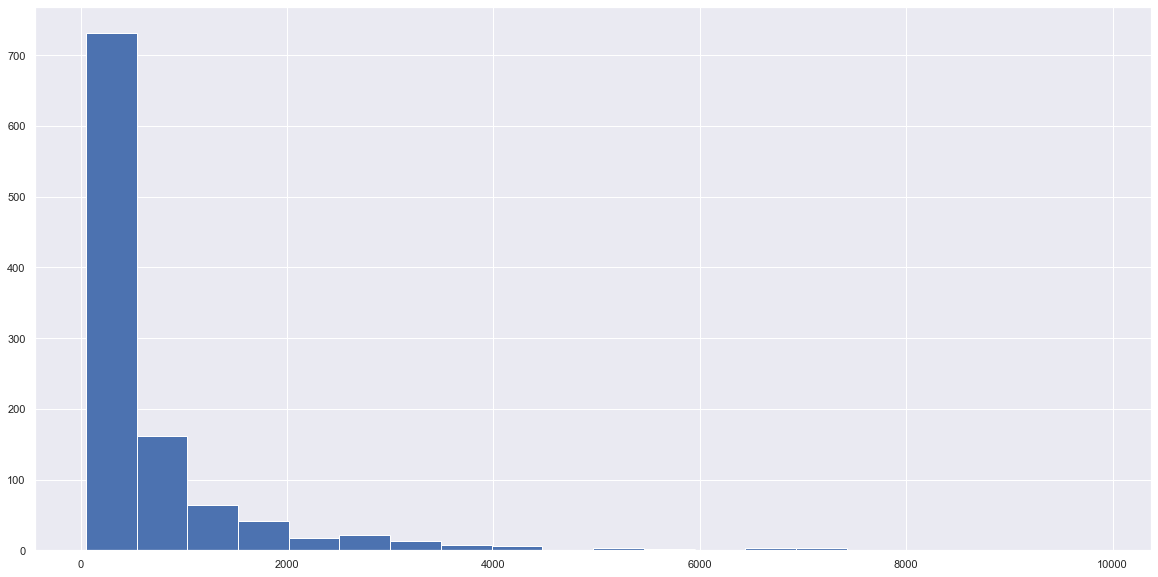

In [62]:
user_history_animals.coub_id.value_counts().hist(bins=20);

As seen the data is skewed, meaning the majority of videos are watched and/or reposted not more often than 1000 times, while some very few have become extremely popular. Which makes sense.

In [63]:
user_history_animals[user_history_animals.user_id==4798352]

,coub_id,user_id,user_name,user_followers_count,user_following_count,reaction_type,title,created_at,duration,tags,views_count,recoubs_count,likes_count,dislikes_count,category_title,url_big,fixed_tags,recoubs_count_cat,likes_count_cat,dislikes_count_cat
0,80296774,4798352,Tefomand76191,16,2679,like,cat,2018-07-21 16:46:19+00:00,8.04,[],26221,19,175,233,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b198/p/c...,[cat],low,low,low
305477,151145903,4798352,Tefomand76191,16,2679,like,Fishing A Duck Lure For MONSTER Pike,2020-08-06 03:20:38+00:00,10.00,"[predator, follow, suspense]",132853,299,1588,310,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b119/p/c...,"[predator, follow, suspense]",high,high,low
551165,153238551,4798352,Tefomand76191,16,2679,like,Soft Power,2020-09-05 16:06:51+00:00,10.00,"[dog power, dog, girl, sleep]",208981,723,3820,35,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b147/p/c...,"[dog power, dog, girl, sleep]",high,high,low


In [64]:
# create year-month column from created_at datetime column
# sort values by year-month, reaction_type, views_count and likes_count, select up to 5 top videos per user
# thus items with 'repost' reaction_type get preference over the same 'liked' ones abd thus have a better chance to get to the final suggestion result 


user_history_animals['created_at_date'] =  user_history_animals.created_at.dt.to_period('M')
user_history_animals = user_history_animals.sort_values(['user_id',
                                                         'reaction_type',
                                                         'created_at_date',
                                                         'views_count',
                                                         'likes_count'],
                                                        ascending = False).groupby(['user_id']).head(5)

user_history_animals = user_history_animals.groupby(['coub_id','user_id','title']).head(1)

/Users/apall/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [65]:
# see distribution of the number of videos per users
user_history_animals.groupby('user_id').count()['user_followers_count'].sort_values(ascending=False).value_counts()


1    36338
5    26990
2    16494
3    10330
4     7675
Name: user_followers_count, dtype: int64

In [66]:
# sort out to select some user with 5 videos that are liked / reposted
user_history_animals.groupby('user_id').count()['user_followers_count'].sort_values(ascending=False).head()



user_id
4152145    5
2377757    5
2377325    5
5124702    5
5124665    5
Name: user_followers_count, dtype: int64

In [67]:
user_history_animals[user_history_animals.user_id == 4152145]

,coub_id,user_id,user_name,user_followers_count,user_following_count,reaction_type,title,created_at,duration,tags,...,recoubs_count,likes_count,dislikes_count,category_title,url_big,fixed_tags,recoubs_count_cat,likes_count_cat,dislikes_count_cat,created_at_date
717199,155128712,4152145,BadRobotSpb,15,16,like,Bird Photobombs Meteorologist,2020-10-04 13:38:45+00:00,10.04,[],...,386,1965,286,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b103/p/c...,"[bird, photobombs, meteorologist]",high,high,low,2020-10
713223,155100558,4152145,BadRobotSpb,15,16,like,Protect the chicks,2020-10-04 01:43:31+00:00,8.24,"[cats, cat, cuteanimalshare, catsoftwitter, ca...",...,275,1459,385,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b103/p/c...,"[cats, cat, cuteanimalshare, catsoftwitter, ca...",high,high,middle,2020-10
736213,155369644,4152145,BadRobotSpb,15,16,like,Infection,2020-10-08 10:20:59+00:00,10.04,"[cat, baby cat]",...,127,551,578,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b139/p/c...,"[cat, baby cat]",middle,middle,high,2020-10
726739,155209713,4152145,BadRobotSpb,15,16,like,,2020-10-05 18:47:12+00:00,10.00,"[cat, piratesofthecaribbean, hesapirate, movie...",...,97,443,608,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b43/p/co...,"[cat, piratesofthecaribbean, hesapirate, movie...",middle,middle,high,2020-10
519720,152970967,4152145,BadRobotSpb,15,16,like,horse s battle,2020-09-01 13:47:48+00:00,6.72,[],...,263,1374,529,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b55/p/co...,"[horse, battle]",high,high,middle,2020-09


In [68]:
def get_user_recommendations(user_id, coub_id=None, df=user_history_animals):
    """
    Returns top-5 suggestions per user. If coub_id is None, takes all available coubs, 
    defines for each top-5 suggestions and takes top-5 out of these based on the similarity score. 
    Otherwise gives top-5 suggestions for the specified video.
    
    Arguments:
        :user_id - ID of the user from the database
        :coub_id - ID of the video of interest for the specified user. Default - None.
        :df - dataframe with all users and their up to 4 watched videos.
    Returns:
        :recommended_videos - dataframe with top-5 suggestions for watching
    """
    
    video_ids = df[df.user_id == user_id].coub_id.values
    
    if coub_id is not None:
        recommended_videos = get_recommendations(coub_id, return_sim_links=True)
    
    else:
        recommended_videos = pd.DataFrame()
        for id in video_ids:
            data = get_recommendations(id, return_sim_links=True)
            recommended_videos = pd.concat([recommended_videos, data])

        recommended_videos = recommended_videos.sort_values(by='sim_score', ascending=False).head()

    return recommended_videos
    

In [69]:
get_user_recommendations(user_id=4152145, coub_id=155128712)

,id,title,sim_score,url_big
361,150123750,birds,0.270196,https://coubsecure-s.akamaihd.net/get/b41/p/co...
11,89848750,Bird,0.209296,https://coubsecure-s.akamaihd.net/get/b201/p/c...
1061,155971911,Bird Dance,0.120409,https://coubsecure-s.akamaihd.net/get/b200/p/c...
322,149763336,If birds had arms,0.104745,https://coubsecure-s.akamaihd.net/get/b143/p/c...
1074,156038330,BIRD MASSAGE,0.087016,https://coubsecure-s.akamaihd.net/get/b150/p/c...


In [70]:
get_user_recommendations(4152145)

,id,title,sim_score,url_big
699,152962743,Мы пойдем с конём,0.466989,https://coubsecure-s.akamaihd.net/get/b59/p/co...
968,155151492,Это маи все все маи,0.423465,https://coubsecure-s.akamaihd.net/get/b119/p/c...
619,152458696,Big Horse,0.275839,https://coubsecure-s.akamaihd.net/get/b51/p/co...
361,150123750,birds,0.270196,https://coubsecure-s.akamaihd.net/get/b41/p/co...
11,89848750,Bird,0.209296,https://coubsecure-s.akamaihd.net/get/b201/p/c...


In the end, I was able to combine purely item based content approach with the hustoric preferences of the user, and the results are good enough for the baseline approach to further finetune. 

Now I'll try to experiment with collaborative filtering approach. For this based on the likes and reposts and dislikes I'll create user rating and will consider the recommendation problem as a regression problem to fix with surprise library algorithms. 

## Classical collaborative filtering with user rating

### Creating individual rating per coub

At present, we face in some respect the 'cold start' problem, in the sense that while having some metadata for the videos we lack individual and average video scores, necessary for the collaborative filtering model. So let's create them. 

We begin by creating the average rating as follows:
- first we define the columns to take part in the cummulative average rating: views_count, recoubs_count, likes_count, dislikes_count;
- we binarize them into **three bins each and assign the value from 2 to 4** with respect to where specific value falls into except for dislikes, which amount to **1 to 3** - we don't want to penalize that much
- apply the following formula:

**R = (views_count(score) + recoubs_count(score) + likes_count(score) - dislikes_count(score))**



Then let's create weighted rating (WR) following the IMDB formula:


\begin{equation*}
WR = \left( \frac{v}{(v + m)} \right) * R + \left( \frac{m}{(v + m)} \right) * C,
\end{equation*}


<!-- tf_{x,y} * log \left( \frac{N}{df_x} \right),   -->

where:
- v - the number of votes for the movie;
- m - the minimum votes required to be listed in the chart;
- R - the average rating of the movie; 
- C - the mean vote across the whole report.

Since we don't have the number of votes, let's create them based on the assumption: **#votes = int(0.10 * #views)**;

The **m**, or minimal number of votes required to be listed is set to be **90% percentile of v**;

**C** is easy to obtain by taking an average accross all ratings in the dataframe

Once the weighted average rating is computed, we can calculate the individual rating of the coub using the following logic: 
- **if the user only liked the coub, the result of WR is multiplied by 1, i.e. equals the WR**; 
- **else if he reposted the coub onto his page, the WR is multiplied by 1.25.**

In [71]:
cols = ['views_count','recoubs_count','likes_count','dislikes_count']

def calculate_R(df):
    """
    Calculates R - the average rating of the video based on specified quantile rules.
    """
    
    labels = np.array([1,2,3])
    vc = pd.cut(df.views_count, 3, labels=labels)#.values#.unique()
    
    rc = pd.cut(df.recoubs_count, 3, labels=labels)
    
    lc = pd.cut(df.likes_count, 3, labels=labels)
    
    dc = pd.cut(df.dislikes_count, 3, labels=labels)
    
    R = pd.DataFrame()
    R['vc'] = vc.astype(int)
    R['rc'] = rc.astype(int)
    R['lc'] = lc.astype(int)
    R['dc'] = dc.astype(int)
    
    # since rating cannot be 0, thus scale by adding 1 to all ratings 
    R = (R['vc'] + R['rc'] + R['lc'] - R['dc']).apply(lambda x: x + 1)
   
    return R
    
    
user_history_animals['R'] = calculate_R(user_history_animals[cols])

user_history_animals['R'].value_counts()

3    80789
1    67385
2    66295
4    18423
5    16090
7    10692
6     3966
8     2326
Name: R, dtype: int64

In [72]:
m = user_history_animals['R'].quantile(0.9)
C = user_history_animals['R'].mean()
    
def calculate_WR(df, m, C):
    
    views_count, R = df
    
    v = int(0.1 * views_count)
    
    WR = (v/(v+m) * R) + (m/(m+v) * C)
    
    return WR


user_history_animals['WR'] = user_history_animals[['views_count','R']].apply(lambda x: calculate_WR(x, m,C), axis=1).apply(int)

user_history_animals['WR'].value_counts()






2    147084
1     67385
3     18423
4     16090
6     10692
5      3966
7      2326
Name: WR, dtype: int64

In [73]:
user_history_animals.head()

,coub_id,user_id,user_name,user_followers_count,user_following_count,reaction_type,title,created_at,duration,tags,...,dislikes_count,category_title,url_big,fixed_tags,recoubs_count_cat,likes_count_cat,dislikes_count_cat,created_at_date,R,WR
778818,156338544,10494865,Wolfgirl pink,0,11,like,bird breakdancer,2020-10-22 21:06:43+00:00,10.00,"[coub, dance, music, коуб, танец, музыка, прир...",...,565,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b172/p/c...,"[coub, dance, music, animal]",middle,low,high,2020-10,1,1
647930,154142166,10494203,AdeLMa,0,11,like,Трюкач,2020-09-19 09:45:58+00:00,9.52,"[dog, dogs, fun, funny, animals, cat, cats, po...",...,563,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b172/p/c...,"[dog, dogs, fun, funny, animals, cat, cats, po...",high,high,high,2020-09,1,1
778660,156336994,10493353,Artyom Pischulin,0,11,like,Little kitty cat is so funny,2020-10-22 20:49:00+00:00,10.00,"[kitty, cats, cat, cuteanimalshare, catsoftwit...",...,177,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b130/p/c...,"[kitty, cats, cat, cuteanimalshare, catsoftwit...",low,low,low,2020-10,3,2
764110,155995340,10493276,Sasuke Uchiha,0,14,like,Leave me alone,2020-10-17 19:59:53+00:00,9.92,"[cat, meow]",...,364,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b104/p/c...,"[cat, meow]",high,high,middle,2020-10,2,2
779112,156341450,10492551,Lohan,0,11,like,Pump it,2020-10-22 21:52:34+00:00,10.00,[],...,315,Animals & Pets,https://coubsecure-s.akamaihd.net/get/b172/p/c...,[pump],low,low,low,2020-10,2,2


In [74]:
# if rating is over 5, we limit it by 5
user_history_animals['user_rating'] = user_history_animals[['user_id', 'WR']].apply(
        lambda x: x[1] if x[0] not in user_ids_repo 
                     else 1.25 * x[1], axis=1).apply(lambda x: 5 if x > 5 else x).apply(int)



user_history_animals['user_rating'].value_counts()

2    147084
1     67385
5     22912
3     18423
4     10162
Name: user_rating, dtype: int64

In [75]:
df = user_history_animals[['user_id','coub_id','user_rating','created_at']].copy()

df['week_day'] = df.created_at.dt.day_name()

df.head()

,user_id,coub_id,user_rating,created_at,week_day
778818,10494865,156338544,1,2020-10-22 21:06:43+00:00,Thursday
647930,10494203,154142166,1,2020-09-19 09:45:58+00:00,Saturday
778660,10493353,156336994,2,2020-10-22 20:49:00+00:00,Thursday
764110,10493276,155995340,2,2020-10-17 19:59:53+00:00,Saturday
779112,10492551,156341450,2,2020-10-22 21:52:34+00:00,Thursday


In [76]:
df.user_rating.value_counts()

2    147084
1     67385
5     22912
3     18423
4     10162
Name: user_rating, dtype: int64

### Data preparation & EDA

Since we have now the rating per movie by the user we can explore a little further the data before proceeding.

In [77]:
from scipy import sparse

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity



In [78]:
print("Total Data:")
print("Total number of video ratings = "+str(df.shape[0]))
print("Number of unique users = "+str(len(np.unique(df["user_id"]))))
print("Number of unique videos = "+str(len(np.unique(df["coub_id"]))))

Total Data:
Total number of video ratings = 265966
Number of unique users = 97827
Number of unique videos = 1081


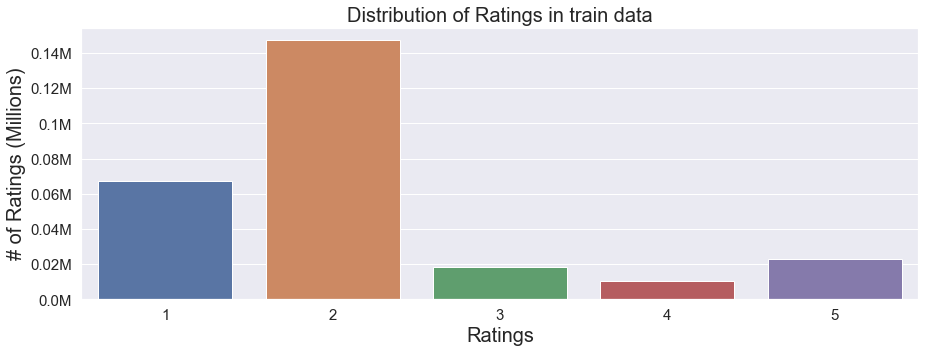

In [79]:
def changingLabels(number):
    return str(number/10**6) + "M"

fig = plt.figure(figsize=(15,5))

ax = sns.countplot(x="user_rating", data=df)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

ax.tick_params(labelsize = 15)
ax.set_title("Distribution of Ratings in train data", fontsize = 20)
ax.set_xlabel("Ratings", fontsize = 20)
ax.set_ylabel("# of Ratings (Millions)", fontsize = 20)
plt.show()


As evident, most of the videos got rating of 2, followed by 1, while higher marks are less frequent. 

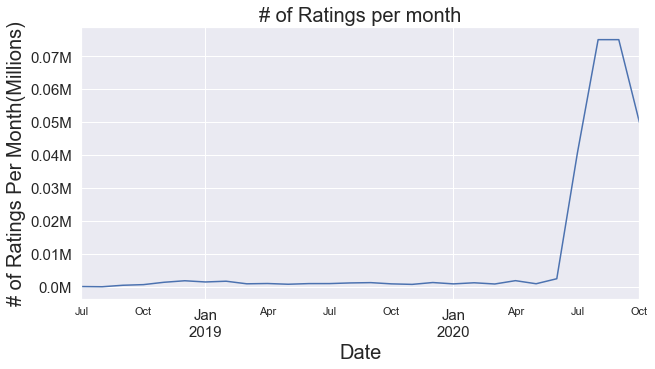

In [80]:
# rankings per months

plt.figure(figsize = (10,5))
ax = df.resample("M", on = "created_at")["user_rating"].count().plot()

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("# of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("# of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()



This graph repeats the earlier distribution of produced and watched videos in the category **Animals-Pets**.

In [81]:
# Ratings Per video

ratings_per_movie = df.groupby(by = 'coub_id')['user_id'].count().sort_values(ascending = False)


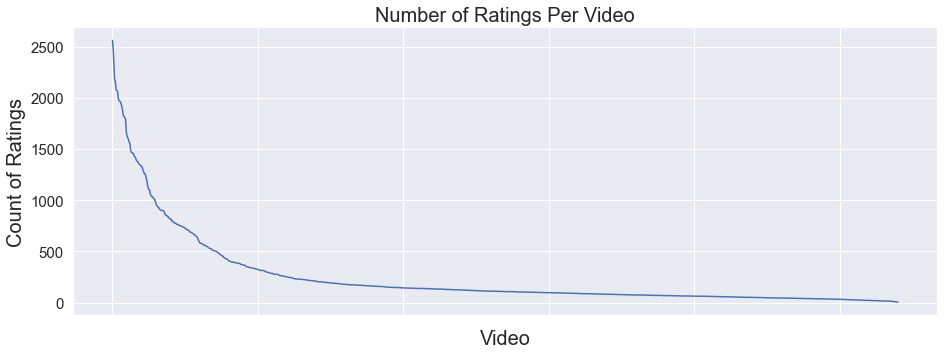

In [82]:
fig = plt.figure(figsize = (12, 4))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Video", fontsize = 20)
plt.xlabel("Video", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

**It is very skewed**

It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies

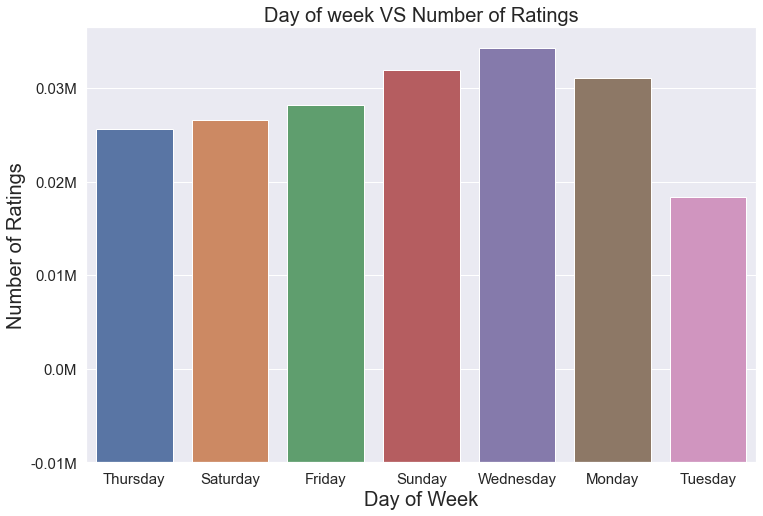

In [83]:
# Video Ratings on Day of Week

fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "week_day", data = df)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

Mostly balanced distribution over the week with Wednesday and Sunday being more popular days for watching and ratings.

In [84]:
average_ratings_dayofweek = df.groupby(by = "week_day")["user_rating"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
week_day
Friday       2.155798
Monday       2.540018
Saturday     2.112844
Sunday       2.036309
Thursday     2.230268
Tuesday      1.675465
Wednesday    2.165834
Name: user_rating, dtype: float64


Despite all, Monday, Saturday and Friday are most generous for giving ratings as good as they can be. :)

### Building the model


While taking user preferences and ratings into consideration dynamically, the classical Collaborative Filtering has some issues. First, the main issue is scalability. The computation grows with both the users and the videos. The worst case complexity is O(mn) with m users and n items. In addition, sparsity is another concern.

One way to handle the scalability and sparsity issue created by collaborative filtering is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

In [85]:
df.head()

,user_id,coub_id,user_rating,created_at,week_day
778818,10494865,156338544,1,2020-10-22 21:06:43+00:00,Thursday
647930,10494203,154142166,1,2020-09-19 09:45:58+00:00,Saturday
778660,10493353,156336994,2,2020-10-22 20:49:00+00:00,Thursday
764110,10493276,155995340,2,2020-10-17 19:59:53+00:00,Saturday
779112,10492551,156341450,2,2020-10-22 21:52:34+00:00,Thursday


In [86]:
def train_algo(input_algo, df, n_splits=5):
    """
    Fits the prediction algorithm from the surprise library and returns it
    Arguments:
        :input_algo - surprise algorithm to fit
        :df - input df
        :n_splits - number of folds for cross validation training. Default 5.
    """
    
    reader = Reader()

    data = Dataset.load_from_df(df[['user_id', 'coub_id', 'user_rating']], reader)


    # define a cross-validation iterator
    kf = KFold(n_splits=n_splits)

    algo = input_algo()

    for fold, (trainset, testset) in enumerate(kf.split(data)):

        # train and test algorithm.
        algo.fit(trainset)
        predictions = algo.test(testset)

        # Compute and print Root Mean Squared Error, MAE
        print(f'Fold {fold}:')
        accuracy.rmse(predictions, verbose=True)
        accuracy.mae(predictions, verbose=True)
        print('---\n')
        
    return algo


algo = train_algo(input_algo=SVD, df=df, n_splits=5)

Fold 0:
RMSE: 0.1326
MAE:  0.0616
---

Fold 1:
RMSE: 0.1323
MAE:  0.0619
---

Fold 2:
RMSE: 0.1302
MAE:  0.0608
---

Fold 3:
RMSE: 0.1312
MAE:  0.0612
---

Fold 4:
RMSE: 0.1316
MAE:  0.0614
---



In [87]:
df.sort_values(by='user_id').head(10)

,user_id,coub_id,user_rating,created_at,week_day
271107,24,150963186,5,2020-08-03 12:45:55+00:00,Monday
550709,24,153226480,5,2020-09-05 12:17:48+00:00,Saturday
347766,46,151371455,4,2020-08-09 09:13:46+00:00,Sunday
472999,305,152635390,1,2020-08-27 14:32:39+00:00,Thursday
535513,710,153138733,5,2020-09-04 04:15:20+00:00,Friday
472147,764,152635390,1,2020-08-27 14:32:39+00:00,Thursday
696332,823,154840511,2,2020-09-29 23:12:10+00:00,Tuesday
549764,823,153226480,4,2020-09-05 12:17:48+00:00,Saturday
702156,823,154883938,2,2020-09-30 18:10:46+00:00,Wednesday
525670,823,153006731,1,2020-09-02 00:55:10+00:00,Wednesday


In [88]:
def recommend_videos(user_id, algo, top=5):
    """
    Returns TOP-N recommendations for the input user.
    Arguments:
        :user_id - user ID
        :algo - input surprise algorithm 
        :top - top N recommendations. Degault 5.
    """
    
    res = []

    for video in df.coub_id.unique():
        res.append((video,algo.predict(user_id,video).est))

    res = pd.DataFrame(res,columns=['coub_id','user_rating']).sort_values(by='user_rating',ascending=False).head(top)
    
    return res


res = recommend_videos(user_id=710, algo=algo, top=5)
res

,coub_id,user_rating
82,153478349,4.946647
110,151869218,4.946087
30,150990021,4.938604
23,151165731,4.937745
170,153138733,4.937267


In [89]:
user_history_animals.columns

Index(['coub_id', 'user_id', 'user_name', 'user_followers_count',
       'user_following_count', 'reaction_type', 'title', 'created_at',
       'duration', 'tags', 'views_count', 'recoubs_count', 'likes_count',
       'dislikes_count', 'category_title', 'url_big', 'fixed_tags',
       'recoubs_count_cat', 'likes_count_cat', 'dislikes_count_cat',
       'created_at_date', 'R', 'WR', 'user_rating'],
      dtype='object')

In [90]:
cols = ['id', 'channel_id', 'title', 'url_big']
res = res.merge(category_data[cols], how='inner', left_on='coub_id', right_on='id')
res

,coub_id,user_rating,id,channel_id,title,url_big
0,153478349,4.946647,153478349,1640331,,https://coubsecure-s.akamaihd.net/get/b22/p/co...
1,151869218,4.946087,151869218,5336785,Sweet homes,https://coubsecure-s.akamaihd.net/get/b117/p/c...
2,150990021,4.938604,150990021,7185721,My nugget my nugget,https://coubsecure-s.akamaihd.net/get/b156/p/c...
3,151165731,4.937745,151165731,5609501,Rise shine,https://coubsecure-s.akamaihd.net/get/b4/p/cou...
4,153138733,4.937267,153138733,1397904,Sealed Loop,https://coubsecure-s.akamaihd.net/get/b163/p/c...


### Subsection results

While switching to the user based rating system I used dimension reduction algorythm and considered the recommendation problem as a regression problem minimizing the RMSE and MAE error. This approach has its advantages, since if some videos got rated high enough, most likely this user  will rate them well too. Plus it's fast enough. Yet the disadvantage of this approach is the limited input data, essentially just the matrix of users and items with respect to their ratings. In the conclusions section I'll share some more ideas how and what could be done to improve initial results.


# Conclusions

---
The purpose of this research notebook has been to demonstrate and try out the different approaches of the SOTA in the realm of the Recommender Systems. Given the nature of the data from *coub* I was able to achieve good results with the hybrid content-based approach, which would include the previous preferences of the given user. Once done I also provided the baseline collaborative filtering model that relies upon SVD with also pretty good results.

While researching the topic I encountered a more advanced approach, for which half of the job has been implemented in the initial version of this notebook, but had to be removed due to much time (over a day for some step and 18 hours for another) for needed to process and train the regressor. I'll briefly enlist now the steps it entailed:

- Once we have the user rating, create user-item matrix and similraty matrices: user-user, and item-item matrices.
- Instead of taking just the rating column advance it and prepare the following features: prepare Global Average of all video ratings, Average rating per User, and Average rating per Video, ratings for the given video by five similar users, ratings of five similar videos to the given one.
- Build different regressors on these data, compare and select best model.

This approach is described in the following resource: 

**How to Build a Recommender System(RS)**: 

https://medium.com/datadriveninvestor/how-to-built-a-recommender-system-rs-616c988d64b2

---

Also, while implementing by me specified approaches, I now realize that approaches provided by me in this solution, merely provide the background for something more advanced, some much more sophisticated approach that truly goes into depth of the conent analysis and building similarity matrix based on feature maps exctrated directly from audio and video channels of the coubs. It would require paramaunt computing capabilities, but could potentially build a much more detailed profile of the user, his preferences and the profile of the videos themselves.

If I think about it, about how I would approach this challenge, the following steps come to my mind:

**Simplified approach - extract key frames from video sequence**
1. Switch from sequence data, which any video is, to a feature map representation of the video. 
2. To do this, select certain number of key frames per video. Convolve them, use 1D convolutions to reduce the output dimensions. 
3. For any coub compare each frame vector with vectors from all other coubs, select top similar videos by IoU.

The disadvantage of this approach would be the lack of context in each video, since the algorithm would compare merely the similarity of what it sees.

Thus:

**More advanced approach - handle video sequence**
1. Extract feature maps for the video sequence of specified length, process audio and video channhels separately. For audio you can look for videos with audio of similar MELS or magnitude. For video you can try video image captioning to extract text representation of each video. Add it to content based model.

2. Think of how you can combine the results of each channel. Add this info to coub ids. 

Audio processing and recommendation based on audio:

1. **Deep Learning in Music Recommendation Systems**
https://www.frontiersin.org/articles/10.3389/fams.2019.00044/full

2. **I Decoded the Spotify Recommendation Algorithm. Here’s What I Found.**
https://medium.com/@ericboam/i-decoded-the-spotify-recommendation-algorithm-heres-what-i-found-4b0f3654035b

3. **Content-Based Music Recommender Systems:Beyond simple Frame-Level Audio Similarity**
http://www.cp.jku.at/people/seyerlehner/supervised/seyerlehner_phd.pdf

4. **Music Recommender System Based on Genre using Convolutional Recurrent Neural Networks**
https://www.sciencedirect.com/science/article/pii/S1877050919310646

5. **NeuralTalk for video image captioning**
https://medium.com/@samim/generating-captions-c31f00e8396e

6. **Dense Video Captioning Using Pytorch**
https://towardsdatascience.com/dense-video-captioning-using-pytorch-392ca0d6971a


---


Unfortunately, we don't have internal statistics on coubs - like how often they're being watched, how long (taking into consideration it's a looped video and with right audio you may want to listen to it long enough), more details on user profile like location, gender, age, etc. 

But you have an app with own video gallery, like Reface does, a lot of this data could be obtained. Which templates are being popular, how long are being watched, whether or not selected for refacing etc. Based on these preferences and applying one of the more advanced approaches above you could substantially enrich the potential database of templates and thus bring more variety into the app. 

Recommender system could be applied to the reface template and user base as well, to suggest increasingly better / personalized templates based on his or her preferences, content similarity and its allignment to the picture of the person. 

A fascinating source of data could also be a video emotion recognition. It seems to have been gaining popularity:
1. **Audio-video Emotion Recognition in the Wild using Deep Hybrid Networks**
https://arxiv.org/pdf/2002.09023v1.pdf

2. **Video-based emotion recognition in the wild using deep transfer learning and score fusion**
https://www.sciencedirect.com/science/article/abs/pii/S0262885617300367


If frontal camera use is permitted to observe users while using the app, an additional whole lot of information layer could become available. 


These all tasks I would definitely love to try my hand on. I realize that there might be some major pitfalls in realizing ideas specified by me in this afterwords section, and some theoretical gaps might be present, given the starting point of not being an expert in video processing etc., but filling these gaps and making it happen could put the whole enterprise of recommending to a whole new level, on pair with Netflix or Youtube, which is an ambitious goal, yet realisable I belive.  